<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

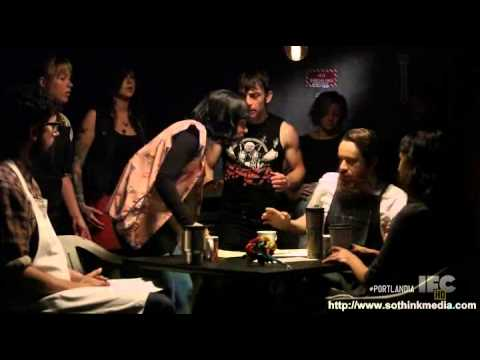

In [23]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [24]:
%pwd

'C:\\Users\\Cooper\\learning\\LS\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [25]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [26]:
shops.nunique()

coffee_shop_name      79
full_review_text    6915
star_rating            5
dtype: int64

In [27]:
# change ratings to integer
shops['star_rating'] = shops['star_rating'].str[1].astype(int)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4


In [28]:
# Remove dates from reviews
# Replace them with spaces for semantic forward-slash usage (e.g. "I liked the ambiance/decor")
shops['full_review_text'] = shops['full_review_text'].replace(regex=True, to_replace=r'\d|/', value=r' ')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,check-in They are located within ...,4


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

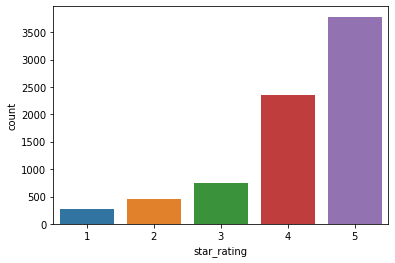

In [29]:
import seaborn as sns
sns.countplot(shops.star_rating);

In [30]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = 
import re

def tokenize(text):
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    return tokens

tokenize("I love this, place, hi!")

['i', 'love', 'this', 'place', 'hi']

In [31]:

shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [32]:
shops.tokens.head()

0    [checkin, love, love, loved, the, atmosphere, ...
1    [listed, in, date, night, austin, ambiance, in...
2    [checkin, listed, in, brunch, spots, i, loved,...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [checkin, they, are, located, within, the, nor...
Name: tokens, dtype: object

In [33]:
from collections import Counter

word_counts = Counter()

shops['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('the', 34811),
 ('and', 26675),
 ('a', 22772),
 ('i', 20250),
 ('to', 17164),
 ('of', 12600),
 ('is', 12000),
 ('coffee', 10440),
 ('was', 9707),
 ('in', 9552)]

In [34]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download en

In [35]:
# import spacy
# from spacy.tokenizer import Tokenizer

# nlp = spacy.load("en_core_web_sm")
# tokenizer = Tokenizer(nlp.vocab)

In [9]:
stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

In [36]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [37]:
wc = count(shops['tokens'])

In [38]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
44,the,6847,34811,1.0,0.045350,0.045350,0.899028
40,and,6867,26675,2.0,0.034751,0.080102,0.901654
1,a,6246,22772,3.0,0.029666,0.109768,0.820116
17,i,5532,20250,4.0,0.026381,0.136149,0.726366
36,to,5653,17164,5.0,0.022361,0.158509,0.742253


In [41]:
# remove stopwords
wc_shops = wc[~wc['word'].isin(stopwords)]
wc_shops.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17,i,5532,20250,4.0,0.026381,0.136149,0.726366
59,coffee,4905,10440,8.0,0.013601,0.204158,0.644039
159,place,3659,5426,20.0,0.007069,0.316882,0.480436
218,good,2789,3975,26.0,0.005178,0.352548,0.366203
209,great,2836,3919,27.0,0.005106,0.357653,0.372374


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [48]:
# subset good and bad shops
good_shops = shops[shops['star_rating'] >= 4]
bad_shops = shops[shops['star_rating'] < 4]

# count words by rating
good_wc = count(good_shops['tokens'])
bad_wc = count(bad_shops['tokens'])

# remove stopwords
good_wc = good_wc[~good_wc['word'].isin(stopwords)]
bad_wc = bad_wc[~bad_wc['word'].isin(stopwords)]

In [68]:
#find negative words
wc['goodness'] = (bad_wc['rank'] - good_wc['rank']) * wc['count']/1000
wc.sort_values(by='goodness').head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,goodness
309,not,2766,4207,25.0,0.005481,0.347369,0.363183,-20673.198
251,friendly,1579,1662,67.0,0.002165,0.483228,0.207327,-7011.978
359,one,1707,2287,49.0,0.002979,0.439039,0.224133,-6067.411
473,food,1388,1869,60.0,0.002435,0.467265,0.182248,-5126.667
1183,now,526,598,195.0,0.000779,0.638721,0.069065,-4435.964
383,been,983,1232,93.0,0.001605,0.531370,0.129070,-3910.368
2511,patio,455,510,229.0,0.000664,0.663302,0.059743,-3839.790
847,espresso,646,850,125.0,0.001107,0.574099,0.084821,-3732.350
624,came,661,762,145.0,0.000993,0.595014,0.086791,-3685.032
1354,say,524,586,200.0,0.000763,0.642550,0.068803,-3575.186


In [69]:
# Find more popular negative words
wc[wc['appears_in_pct'] > 0.001].sort_values(by='goodness').head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,goodness
309,not,2766,4207,25.0,0.005481,0.347369,0.363183,-20673.198
251,friendly,1579,1662,67.0,0.002165,0.483228,0.207327,-7011.978
359,one,1707,2287,49.0,0.002979,0.439039,0.224133,-6067.411
473,food,1388,1869,60.0,0.002435,0.467265,0.182248,-5126.667
1183,now,526,598,195.0,0.000779,0.638721,0.069065,-4435.964
383,been,983,1232,93.0,0.001605,0.531370,0.129070,-3910.368
2511,patio,455,510,229.0,0.000664,0.663302,0.059743,-3839.790
847,espresso,646,850,125.0,0.001107,0.574099,0.084821,-3732.350
624,came,661,762,145.0,0.000993,0.595014,0.086791,-3685.032
1354,say,524,586,200.0,0.000763,0.642550,0.068803,-3575.186


In [71]:
# Find positive words
wc.sort_values(by='goodness', ascending=False).head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,goodness
17,i,5532,20250,4.0,0.026381,0.136149,0.726366,7472.250
82,just,1916,2615,41.0,0.003407,0.413660,0.251576,6592.415
218,good,2789,3975,26.0,0.005178,0.352548,0.366203,5811.450
159,place,3659,5426,20.0,0.007069,0.316882,0.480436,3141.654
1697,cream,462,833,130.0,0.001085,0.579552,0.060662,2993.802
1186,two,593,747,150.0,0.000973,0.599931,0.077862,2881.926
210,drinks,905,1129,102.0,0.001471,0.545229,0.118829,2779.598
463,get,1858,2427,46.0,0.003162,0.429993,0.243960,2647.857
126,try,1040,1191,98.0,0.001552,0.539249,0.136555,2595.189
72,nice,1463,1741,64.0,0.002268,0.476660,0.192096,2592.349


In [73]:
# Another metric, "positivity". Difference in appears_in_pct
wc['positivity'] = good_wc['appears_in_pct'] - bad_wc['appears_in_pct']
# least positive
wc.sort_values(by='positivity').head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,goodness,positivity
46,heart,112,132,675.0,0.000172,0.810659,0.014706,-74.184,-0.625853
13,art,224,246,423.0,0.000320,0.751251,0.029412,-84.132,-0.456046
10,level,71,73,1055.0,0.000095,0.859523,0.009322,-70.664,-0.373019
449,creating,20,20,2433.0,0.000026,0.930039,0.002626,-38.240,-0.236906
105,swing,45,50,1399.0,0.000065,0.886784,0.005909,-54.800,-0.236736
217,extra,139,149,615.0,0.000194,0.799723,0.018251,-260.750,-0.229642
304,honestly,130,148,618.0,0.000193,0.800304,0.017069,-42.032,-0.201863
161,s,117,133,669.0,0.000173,0.809621,0.015362,-83.391,-0.200301
164,thoroughly,20,20,2431.0,0.000026,0.929987,0.002626,-43.200,-0.187448
236,very,1826,2443,45.0,0.003183,0.426831,0.239758,-412.867,-0.181642


In [74]:
wc.sort_values(by='positivity', ascending=False).head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,goodness,positivity
17,i,5532,20250,4.0,0.026381,0.136149,0.726366,7472.250,0.665812
159,place,3659,5426,20.0,0.007069,0.316882,0.480436,3141.654,0.461049
209,great,2836,3919,27.0,0.005106,0.357653,0.372374,1783.145,0.382828
255,northcross,8,8,4043.0,0.000010,0.957598,0.001050,5.504,0.338873
86,austin,1789,2253,50.0,0.002935,0.441974,0.234900,2318.337,0.243987
219,feels,118,122,720.0,0.000159,0.818127,0.015494,182.146,0.222078
82,just,1916,2615,41.0,0.003407,0.413660,0.251576,6592.415,0.218463
268,lots,412,463,256.0,0.000603,0.680436,0.054097,831.085,0.211055
297,pricey,109,110,783.0,0.000143,0.827672,0.014312,28.050,0.201741
72,nice,1463,1741,64.0,0.002268,0.476660,0.192096,2592.349,0.186573


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

